In [1]:
import torch
import torch.nn as nn

# state space approximation of the underdamped spring-mass-damper system
class PhysicsInformedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, m, c, k):
        super(PhysicsInformedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        # State space matrices for the underdamped spring
        self.A = torch.tensor([[0, 1], [-k/m, -c/m]], dtype=torch.float32)
        self.B = torch.tensor([[0], [1]], dtype=torch.float32)  # Assuming a zero input (free response)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def physics_loss(self, x):
        # x is the state vector
        dx = torch.matmul(self.A, x.T).T  # Calculate the state derivative
        return dx

# Example usage
m = 1.0  # Mass
c = 0.2  # Damping coefficient
k = 1.0  # Spring constant

model = PhysicsInformedNN(input_dim=2, hidden_dim=50, output_dim=2, m=m, c=c, k=k)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Dummy data (initial state and zero input for simplicity)
x = torch.randn(10, 2)

# Forward pass
output = model(x)

# Compute physics-based loss
loss = model.physics_loss(x).mean()  # Mean of the physics loss over the batch

loss


tensor(-0.1713)

# Kolmorgorov-Arnold Network (KAN)

In [3]:
import numpy as np
import torch
import torch.optim as optim
import models as pim
import losses as pil

# Initialize model, optimizer, and training parameters
model = pim.KAN(
            layers_hidden=[1, 50, 50, 1],  # Define the layer sizes
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.Tanh,
            grid_eps=0.02,
            grid_range=[-1, 1]
        )
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

d, w0 = 2, 20
mu, k = 2*d, w0**2

d, w0 = torch.Tensor([d]), torch.Tensor([w0])
mu, k = torch.Tensor([mu]), torch.Tensor([k])

plosses = []
dlosses = []

# list to track moving average of loss
losses = []  # moving average of loss

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()

    ploss, dloss, icloss = pil.physics_loss(model, mu, k, d, w0)
    ploss *= 1e-4
    # loss = ploss + dloss + icloss
    loss = dloss
    loss.backward()
    optimizer.step()

    # calculate moving average of loss
    if len(losses) < 100:
        losses.append(loss.item())
    else:
        losses.pop(0)
        losses.append(loss.item())
    
    # check if loss has converged
    std = np.std(losses)
    mean = np.mean(losses)
    if len(losses) == 100 and std < 5e-6 and epoch > 1000 and loss.item() < 1e-5:
        print(f'Converged at epoch {epoch}')
        break
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch},\
        Loss: {mean:.3e},\
        Physics Loss: {ploss.item():.3e},\
        Data Loss: {dloss.item():.3e},\
        IC Loss: {icloss.item():.3e},\
        Loss Std: {std:.3e}')
        scheduler.step()
    
    plosses.append(ploss.item())
    dlosses.append(dloss.item())


Epoch 0,        Loss: 2.356e-01,        Physics Loss: 4.538e-01,        Data Loss: 2.356e-01,        IC Loss: 1.153e+00,        Loss Std: 0.000e+00
Epoch 100,        Loss: 2.399e-01,        Physics Loss: 1.618e+00,        Data Loss: 1.883e-01,        IC Loss: 4.806e+00,        Loss Std: 5.500e-02
Epoch 200,        Loss: 2.069e-01,        Physics Loss: 4.069e+00,        Data Loss: 1.393e-01,        IC Loss: 3.699e+01,        Loss Std: 5.334e-02
Epoch 300,        Loss: 1.208e-01,        Physics Loss: 4.159e+01,        Data Loss: 3.666e-02,        IC Loss: 2.376e+02,        Loss Std: 5.581e-02
Epoch 400,        Loss: 1.050e-02,        Physics Loss: 5.959e+01,        Data Loss: 3.022e-03,        IC Loss: 9.311e+01,        Loss Std: 8.631e-03
Epoch 500,        Loss: 1.190e-03,        Physics Loss: 5.331e+01,        Data Loss: 3.697e-04,        IC Loss: 5.839e+01,        Loss Std: 1.017e-03
Epoch 600,        Loss: 5.223e-04,        Physics Loss: 4.908e+01,        Data Loss: 2.122e-04,       

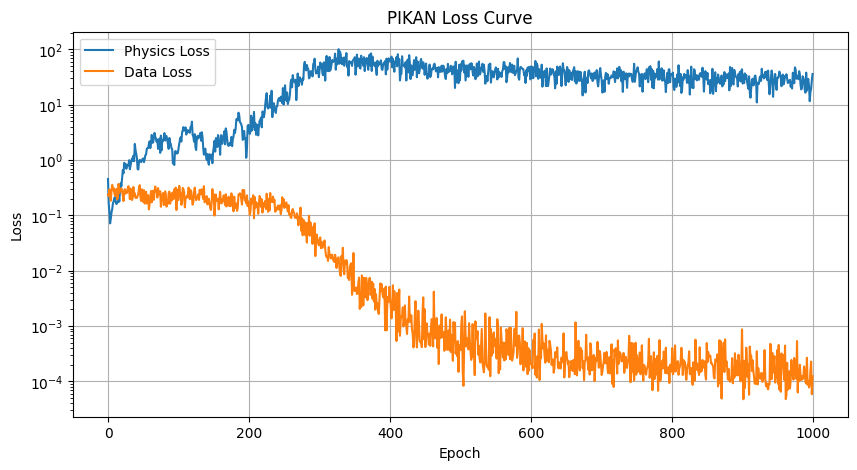

In [5]:
import matplotlib.pyplot as plt

# plot log loss curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(plosses, label='Physics Loss')
ax.plot(dlosses, label='Data Loss')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PIKAN Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
#plot predicted vs true displacement
model.eval()
td = torch.linspace(0, 2, 120).reshape(-1, 1).requires_grad_(True)
t0 = torch.FloatTensor(1).fill_(0.0).reshape(-1, 1)
tn = torch.FloatTensor(119, 1).uniform_(0, 2)
# tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1)
tp = torch.concat([t0, tn])
x = model(td).squeeze().detach().numpy()
x_true = oscillator(d, w0, td).squeeze().detach().numpy()

td = td.squeeze().detach().numpy()
data_domain_mask = td<=0.5
physics_domain_mask = tp<=1.0



fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(td, x, color="red", label='Predicted')
ax.plot(td, x_true, color="black", linestyle='--', label='True')
plt.scatter(td[data_domain_mask], x_true[data_domain_mask], color="tab:blue", alpha=0.8, label="Training data")
plt.scatter(tp[physics_domain_mask], 0*tp[physics_domain_mask], color="tab:green", alpha=0.8, label="Physics domain")
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('PIKAN Predicted vs True Displacement')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'oscillator' is not defined

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Parameters
T = 200  # Total time steps
n = 5    # State dimension
m = 2    # Input dimension
k = 3    # Output dimension

# Generate random inputs
u_t = torch.randn(T, m)

# Initialize state and output arrays
x_t = torch.zeros(T, n)
y_t = torch.zeros(T, k)

# True underlying functions (unknown in practice)
def true_f(x, u):
    return torch.tanh(torch.matmul(x, true_A.T) + torch.matmul(u, true_B.T))

def true_g(x, u):
    return torch.matmul(x, true_C.T) + torch.matmul(u, true_D.T)

# Randomly initialize true system matrices
true_A = torch.randn(n, n)
true_B = torch.randn(n, m)
true_C = torch.randn(k, n)
true_D = torch.randn(k, m)

# Generate the time-series data
for t in range(T - 1):
    x_t[t + 1] = true_f(x_t[t], u_t[t]) + 0.1 * torch.randn(n)
    y_t[t] = true_g(x_t[t], u_t[t]) + 0.1 * torch.randn(k)

# Define KANetwork
class KANetwork(nn.Module):
    def __init__(self, n_state, n_input, n_output, n_hidden, Q):
        super(KANetwork, self).__init__()
        self.n_state = n_state
        self.n_input = n_input
        self.n_output = n_output  # Ensure this is correctly set
        self.Q = Q  # Number of terms in the K-A sum
        self.n_hidden = n_hidden  # Store n_hidden

        # Define univariate functions ψ_pq and γ_rq as linear layers with activation
        self.psi_layers = nn.ModuleList([
            nn.Sequential(nn.Linear(1, n_hidden), nn.Tanh()) for _ in range(n_state * Q)
        ])
        self.gamma_layers = nn.ModuleList([
            nn.Sequential(nn.Linear(1, n_hidden), nn.Tanh()) for _ in range(n_input * Q)
        ])
        # Define φ_q functions as linear layers with activation
        self.phi_layers = nn.ModuleList([
            nn.Sequential(nn.Linear(n_hidden, self.n_output), nn.Tanh()) for _ in range(Q)
        ])

    def forward(self, x, u):
        batch_size = x.size(0)
        s_q = []

        for q in range(self.Q):
            # Initialize sums with the correct shape
            psi_sum = torch.zeros(batch_size, self.n_hidden)
            gamma_sum = torch.zeros(batch_size, self.n_hidden)

            # Sum over ψ_pq(x_p)
            for p in range(self.n_state):
                idx = q * self.n_state + p
                x_p = x[:, p].unsqueeze(1)  # Shape: (batch_size, 1)
                psi_out = self.psi_layers[idx](x_p)  # Shape: (batch_size, n_hidden)
                psi_sum += psi_out  # Shape: (batch_size, n_hidden)

            # Sum over γ_rq(u_r)
            for r in range(self.n_input):
                idx = q * self.n_input + r
                u_r = u[:, r].unsqueeze(1)  # Shape: (batch_size, 1)
                gamma_out = self.gamma_layers[idx](u_r)  # Shape: (batch_size, n_hidden)
                gamma_sum += gamma_out  # Shape: (batch_size, n_hidden)

            # Compute φ_q(s_q)
            s_q_current = psi_sum + gamma_sum  # Shape: (batch_size, n_hidden)
            phi_out = self.phi_layers[q](s_q_current)  # Shape: (batch_size, n_output)
            s_q.append(phi_out)

        # Stack and sum over q
        output = torch.stack(s_q, dim=0)  # Shape: (Q, batch_size, n_output)
        output = torch.sum(output, dim=0)  # Shape: (batch_size, n_output)
        return output

# Define StateSpaceModel
class StateSpaceModel(nn.Module):
    def __init__(self, n_state, n_input, n_output, n_hidden, Q):
        super(StateSpaceModel, self).__init__()
        self.n_state = n_state
        self.n_input = n_input
        self.n_output = n_output

        # K-A Network for state transition function f
        self.f_network = KANetwork(n_state, n_input, n_state, n_hidden, Q)

        # K-A Network for observation function g
        self.g_network = KANetwork(n_state, n_input, n_output, n_hidden, Q)

    def forward(self, x_t, u_t):
        # Predict next state
        x_next = self.f_network(x_t, u_t)  # Shape: (batch_size, n_state)

        # Predict observation
        y_pred = self.g_network(x_t, u_t)  # Shape: (batch_size, n_output)
        return x_next, y_pred

# Hyperparameters
n_hidden = 8  # Hidden layer size for univariate functions
Q = 2 * n  # Number of terms in the K-A sum
learning_rate = 0.001
num_epochs = 50

# Initialize the model
model = StateSpaceModel(n_state=n, n_input=m, n_output=k, n_hidden=n_hidden, Q=Q)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare data loaders
batch_size = 16
dataset = torch.utils.data.TensorDataset(x_t[:-1], u_t[:-1], y_t[:-1], x_t[1:])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch, u_batch, y_batch, x_next_batch = batch

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        x_pred, y_pred = model(x_batch, u_batch)

        # Compute loss (state prediction and output prediction)
        loss_state = criterion(x_pred, x_next_batch)
        loss_output = criterion(y_pred, y_batch)
        loss = loss_state + loss_output

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 1 == 0:
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')



Epoch [1/50], Loss: 6.0738
Epoch [2/50], Loss: 4.4577
Epoch [3/50], Loss: 3.7354
Epoch [4/50], Loss: 3.1252
Epoch [5/50], Loss: 2.6491
Epoch [6/50], Loss: 2.1494
Epoch [7/50], Loss: 1.8078
Epoch [8/50], Loss: 1.5525
Epoch [9/50], Loss: 1.3355
Epoch [10/50], Loss: 1.1409
Epoch [11/50], Loss: 0.9731
Epoch [12/50], Loss: 0.8362
Epoch [13/50], Loss: 0.7309
Epoch [14/50], Loss: 0.6385
Epoch [15/50], Loss: 0.5644
Epoch [16/50], Loss: 0.5018
Epoch [17/50], Loss: 0.4533
Epoch [18/50], Loss: 0.4052
Epoch [19/50], Loss: 0.3806
Epoch [20/50], Loss: 0.3508
Epoch [21/50], Loss: 0.3342
Epoch [22/50], Loss: 0.3061
Epoch [23/50], Loss: 0.2827
Epoch [24/50], Loss: 0.2641
Epoch [25/50], Loss: 0.2547
Epoch [26/50], Loss: 0.2427
Epoch [27/50], Loss: 0.2397
Epoch [28/50], Loss: 0.2396
Epoch [29/50], Loss: 0.2169
Epoch [30/50], Loss: 0.2229
Epoch [31/50], Loss: 0.2136
Epoch [32/50], Loss: 0.2095
Epoch [33/50], Loss: 0.1893
Epoch [34/50], Loss: 0.1899
Epoch [35/50], Loss: 0.1893
Epoch [36/50], Loss: 0.1836
E

Step 0: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 1: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 2: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 3: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 4: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 5: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 6: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 7: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 8: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 9: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 10: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 11: x_current shape: torch.Size([1, 5]), x_next shape: torch.Size([1, 5])
Step 12: x_current shape: torch.Size([1, 5]), x_next shape: to

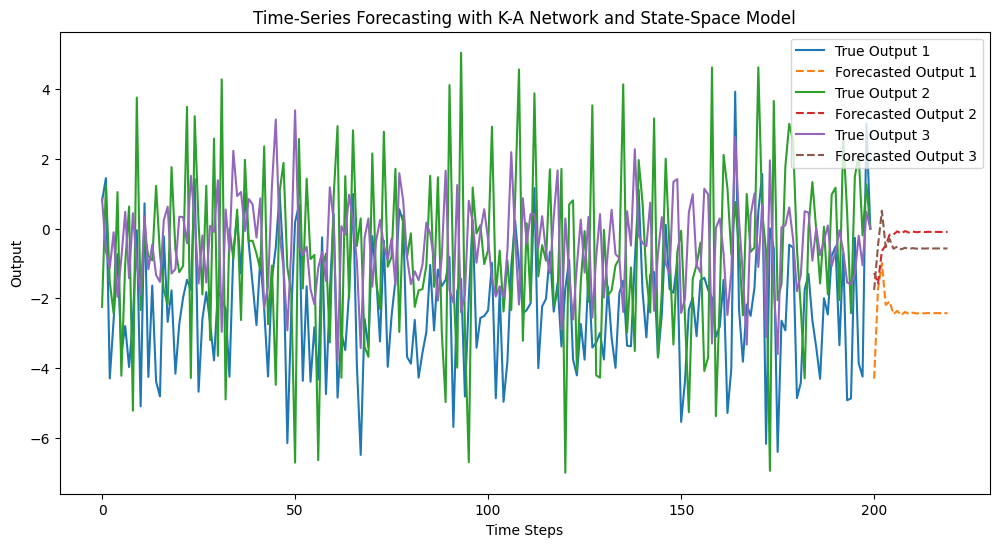

In [8]:
# Number of steps to forecast
forecast_steps = 20

# Starting from the last available state and input
x_current = x_t[-1].unsqueeze(0)  # Shape: (1, n_state)
u_current = u_t[-1].unsqueeze(0)  # Shape: (1, n_input)

x_forecast = []
y_forecast = []

for step in range(forecast_steps):
    with torch.no_grad():
        x_next, y_pred = model(x_current, u_current)

    print(f"Step {step}: x_current shape: {x_current.shape}, x_next shape: {x_next.shape}")

    x_forecast.append(x_next.squeeze(0).numpy())
    y_forecast.append(y_pred.squeeze(0).numpy())

    # Update current state and input (here we assume u_t remains the same for simplicity)
    x_current = x_next  # x_current should have shape (1, n_state)
    # For demonstration, we'll use zero input or repeat the last input
    u_current = torch.zeros_like(u_current)

# Convert forecasts to numpy arrays
x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

# Plot the forecasted outputs
time_steps = np.arange(T)
forecast_time_steps = np.arange(T, T + forecast_steps)

plt.figure(figsize=(12, 6))
for i in range(k):
    plt.plot(time_steps, y_t[:T, i], label=f'True Output {i+1}')
    plt.plot(forecast_time_steps, y_forecast[:, i], '--', label=f'Forecasted Output {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Output')
plt.legend()
plt.title('Time-Series Forecasting with K-A Network and State-Space Model')
plt.show()


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Parameters
omega_n = 2 * np.pi  # Natural frequency (1 Hz)
zeta = 0.1           # Damping ratio (underdamped)
Delta_t = 0.01       # Time step
T_total = 20         # Total time in seconds
T = int(T_total / Delta_t)  # Total number of time steps

# State-space matrices
A = np.array([[0, 1], [-omega_n**2, -2 * zeta * omega_n]])
C = np.array([[1, 0]])  # We observe the displacement

# Initialize state and output arrays
x_t = np.zeros((T, 2))  # State vector: [displacement, velocity]
y_t = np.zeros(T)       # Observed displacement

# Initial conditions
x_t[0, 0] = 1.0  # Initial displacement
x_t[0, 1] = 0.0  # Initial velocity

# Simulate the system
for t in range(T - 1):
    dx_dt = A @ x_t[t]
    x_t[t + 1] = x_t[t] + Delta_t * dx_dt
    y_t[t] = C @ x_t[t]

# Convert to PyTorch tensors
x_t = torch.tensor(x_t, dtype=torch.float32)
y_t = torch.tensor(y_t, dtype=torch.float32).unsqueeze(1)  # Shape: (T, 1)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Parameters
omega_n = 2 * np.pi  # Natural frequency (1 Hz)
zeta = .01         # Damping ratio (underdamped)
Delta_t = 0.01       # Time step
T_total = 20         # Total time in seconds
T = int(T_total / Delta_t)  # Total number of time steps

# State-space matrices
A = np.array([[0, 1], [-omega_n**2, -2 * zeta * omega_n]])
C = np.array([[1, 0]])  # We observe the displacement


# Initialize state and output arrays
x_t = np.zeros((T, 2))  # State vector: [displacement, velocity]
y_t = np.zeros(T)       # Observed displacement

# Initial conditions
x_t[0, 0] = 1.0  # Initial displacement
x_t[0, 1] = 0.0  # Initial velocity

# Simulate the system
for t in range(T - 1):
    dx_dt = A @ x_t[t]
    x_t[t + 1] = x_t[t] + Delta_t * dx_dt
    y_t[t] = C @ x_t[t]

# Convert to PyTorch tensors
x_t = torch.tensor(x_t, dtype=torch.float32)
y_t = torch.tensor(y_t, dtype=torch.float32).unsqueeze(1)  # Shape: (T, 1)


In [27]:
class KANetwork(nn.Module):
    def __init__(self, n_state, n_output, n_hidden, Q):
        super(KANetwork, self).__init__()
        self.n_state = n_state
        self.n_output = n_output
        self.Q = Q
        self.n_hidden = n_hidden

        # Use ReLU activation functions
        self.psi_layers = nn.ModuleList([
            nn.Sequential(nn.Linear(1, n_hidden), nn.ReLU()) for _ in range(n_state * Q)
        ])
        self.phi_layers = nn.ModuleList([
            nn.Sequential(nn.Linear(n_hidden, self.n_output), nn.ReLU()) for _ in range(Q)
        ])


    def forward(self, x):
        batch_size = x.size(0)
        s_q = []

        for q in range(self.Q):
            # Initialize sum with the correct shape
            psi_sum = torch.zeros(batch_size, self.n_hidden)

            # Sum over ψ_pq(x_p)
            for p in range(self.n_state):
                idx = q * self.n_state + p
                x_p = x[:, p].unsqueeze(1)  # Shape: (batch_size, 1)
                psi_out = self.psi_layers[idx](x_p)  # Shape: (batch_size, n_hidden)
                psi_sum += psi_out  # Shape: (batch_size, n_hidden)

            # Compute φ_q(s_q)
            s_q_current = psi_sum  # Shape: (batch_size, n_hidden)
            phi_out = self.phi_layers[q](s_q_current)  # Shape: (batch_size, n_output)
            s_q.append(phi_out)

        # Stack and sum over q
        output = torch.stack(s_q, dim=0)  # Shape: (Q, batch_size, n_output)
        output = torch.sum(output, dim=0)  # Shape: (batch_size, n_output)
        return output


In [28]:
class StateSpaceModel(nn.Module):
    def __init__(self, n_state, n_output, n_hidden, Q):
        super(StateSpaceModel, self).__init__()
        self.n_state = n_state
        self.n_output = n_output

        # K-A Network for state transition function f
        self.f_network = KANetwork(n_state, n_state, n_hidden, Q)

        # K-A Network for observation function g
        self.g_network = KANetwork(n_state, n_output, n_hidden, Q)

    def forward(self, x_t):
        # Predict next state
        x_next = self.f_network(x_t)  # Shape: (batch_size, n_state)

        # Predict observation
        y_pred = self.g_network(x_t)  # Shape: (batch_size, n_output)
        return x_next, y_pred


In [30]:
# Prepare training data
x_train = x_t[:-1]  # Shape: (T-1, n_state)
y_train = y_t[:-1]  # Shape: (T-1, 1)
x_next_train = x_t[1:]  # Shape: (T-1, n_state)




# Hyperparameters
n_state = 2  # State dimension
n_output = 1  # Output dimension
n_hidden = 16  # Hidden layer size for univariate functions
Q = 2 * n_state  # Number of terms in the K-A sum
learning_rate = 0.001
num_epochs = 100

# Initialize the model
model = StateSpaceModel(n_state=n_state, n_output=n_output, n_hidden=n_hidden, Q=Q)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Prepare data loaders
batch_size = 32
dataset = torch.utils.data.TensorDataset(x_train, x_next_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch, x_next_batch, y_batch = batch

        # Normalize the state and output data
        x_mean = x_batch.mean(dim=0)
        x_std = x_batch.std(dim=0)
        x_batch = (x_batch - x_mean) / x_std

        # Normalize the state and output data
        x_mean = x_next_batch.mean(dim=0)
        x_std = x_next_batch.std(dim=0)
        x_next_batch = (x_next_batch - x_mean) / x_std

        y_mean = y_batch.mean()
        y_std = y_batch.std()
        y_batch = (y_batch - y_mean) / y_std

        # Use x_t_norm and y_t_norm in training


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        x_pred, y_pred = model(x_batch)

        # Compute loss (state prediction and output prediction)
        loss_state = criterion(x_pred, x_next_batch)
        loss_output = criterion(y_pred, y_batch)
        loss = loss_state + loss_output

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')


Epoch [10/100], Loss: 0.965636
Epoch [20/100], Loss: 0.965594
Epoch [30/100], Loss: 0.966365
Epoch [40/100], Loss: 0.960643
Epoch [50/100], Loss: 0.962848
Epoch [60/100], Loss: 0.955553
Epoch [70/100], Loss: 0.978685
Epoch [80/100], Loss: 0.968864


KeyboardInterrupt: 

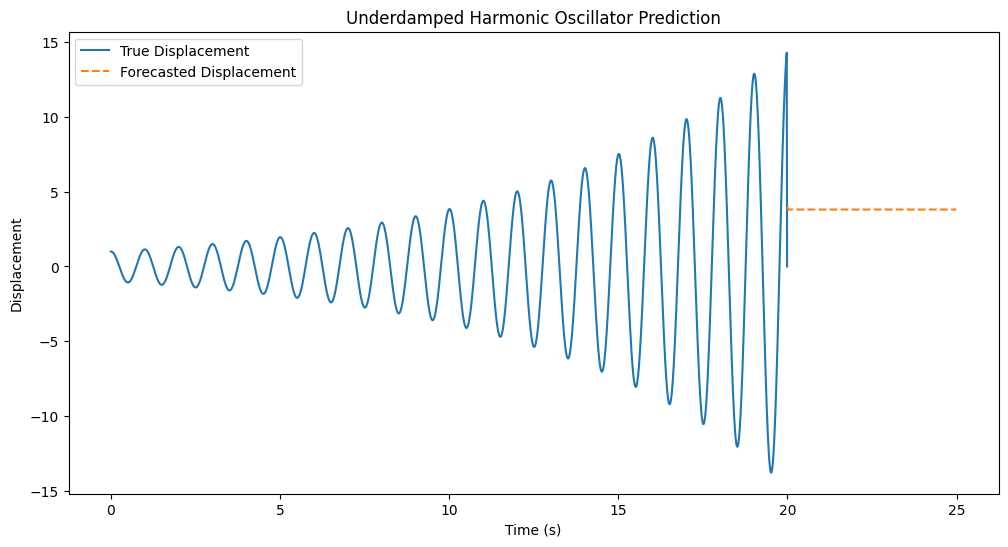

In [26]:
# Number of steps to forecast
forecast_steps = int(5 / Delta_t)  # Predict 5 seconds into the future

# Starting from the last available state
x_current = x_t[-1].unsqueeze(0)  # Shape: (1, n_state)

x_forecast = []
y_forecast = []

for step in range(forecast_steps):
    with torch.no_grad():
        x_next, y_pred = model(x_current)

    x_forecast.append(x_next.squeeze(0).numpy())
    y_forecast.append(y_pred.squeeze(0).numpy())

    # Update current state
    x_current = x_next  # Shape: (1, n_state)

# Convert forecasts to numpy arrays
x_forecast = np.array(x_forecast)  # Shape: (forecast_steps, n_state)
y_forecast = np.array(y_forecast).flatten()  # Shape: (forecast_steps,)

# Time vectors
time_steps = np.arange(0, T_total, Delta_t)
forecast_time_steps = np.arange(T_total, T_total + forecast_steps * Delta_t, Delta_t)

# Plot the true and predicted displacement
plt.figure(figsize=(12, 6))
plt.plot(time_steps, y_t.numpy().flatten(), label='True Displacement')
plt.plot(forecast_time_steps, y_forecast, '--', label='Forecasted Displacement')
plt.xlabel('Time (s)')
plt.ylabel('Displacement')
plt.legend()
plt.title('Underdamped Harmonic Oscillator Prediction')
plt.show()
